In [1]:
import os
import json
import cv2
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [4]:
file = 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells'
img_lst = 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_images\\*.jpg'
msk_lst = 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\*.tif'

image_list = sorted(glob.glob(img_lst))
#image_list = image_list[10:31]
mask_list = sorted(glob.glob(msk_lst))

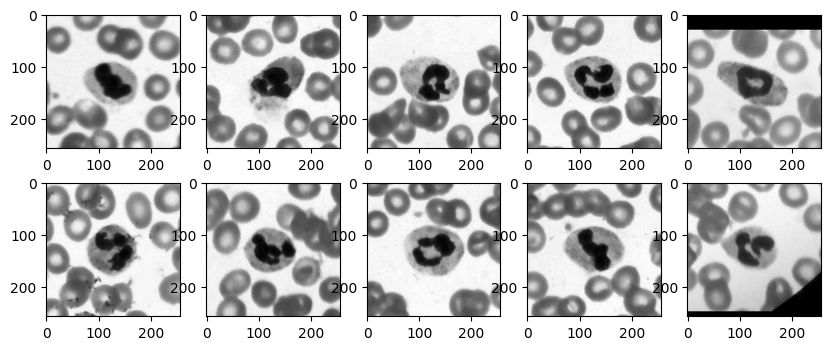

In [5]:
for i in range(10):
    img = tf.io.read_file(image_list[i])
    img1 = tf.image.decode_jpeg(img)
    img2 = tf.keras.layers.Lambda(lambda x: x / 255)(img1)
    img3 = tf.image.resize(img2,[256,256])
    img4 = tf.image.rgb_to_grayscale(img3)
    plt.subplot(2, 5,i + 1)
    plt.imshow(img4,cmap='gray')
    plt.gcf().set_size_inches(10, 4)
plt.show()

In [6]:
mask_list

['F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_10_3.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_11_1.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_12_1.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_13_1.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_15_2.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_18_2.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_1_1.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_1_2.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_1_3.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_1_4.tif',
 'F:\\Exprement\\saturn\\img-pro\\Datasets\\Blood_cells\\train_masks\\95-8-6-1_20_1.tif',
 'F:\\Expremen

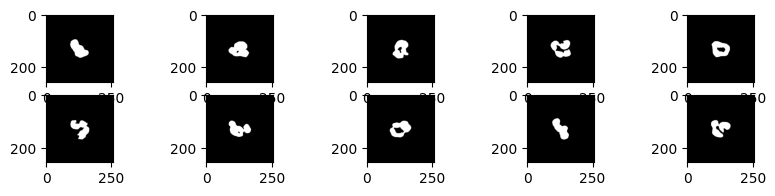

In [7]:
for i in range(10):
    img = plt.imread(mask_list[i])
    img = np.expand_dims(img, axis=-1)
    img = tf.image.resize(img,[256,256])
    #img = tf.cast(img * 255, tf.uint8)
    #img = tf.clip_by_value(img, 0, 255)
    plt.subplot(4, 5,i + 1)
    plt.imshow(img.numpy(),cmap='gray')
    plt.gcf().set_size_inches(10, 4)
plt.show()

In [8]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # avoid varning message

from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras_unet_collection import models,losses

In [9]:
def shape_data(img):
    img=cv2.resize(img,(256,256))
    img=cv2.normalize(img,None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img 

In [10]:
train,label=[],[]

for j in mask_list:
    img1=plt.imread(j)
    #img1=tf.reduce_mean(img1, axis=-1)
    img1=tf.expand_dims(img1, axis=-1) 
    img1=tf.image.resize(img1,[256,256])
    label.append(img1)
    
for j in image_list:
    img2=cv2.imread(j)
    train.append(shape_data(img2))

In [11]:
len(train),train[0].shape,label[0].shape,len(label)

(50, (256, 256, 3), TensorShape([256, 256, 1]), 50)

In [12]:
train=np.array(train).reshape(-1,256,256,3)
label=np.array(label).reshape(-1,256,256,1)

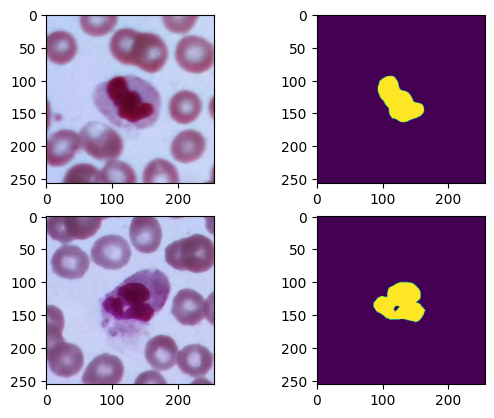

In [13]:
fig, plot = plt.subplots(2, 2)
plot[0,0].imshow(train[0])
plot[0,1].imshow(label[0])
plot[1,0].imshow(train[1])
plot[1,1].imshow(label[1])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train[:len(label)], label, test_size=0.22, random_state=42)

In [34]:
# res-unet
from keras.models import Model

def model1 ():
    
#     s = tf.io.read_file(pic)
#     s = tf.image.decode_jpeg(s)
#     s = tf.keras.layers.Lambda(lambda x: x / 255)(s)
#     s = tf.keras.layers.Resizing(s,[256,256,3])
    
    inputs = tf.keras.layers.Input((256,256,3))
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [35]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

In [36]:
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [37]:
from focal_loss import BinaryFocalLoss

model_unet = model1()
model_unet.compile(optimizer=Adam(1e-4), loss = BinaryFocalLoss(gamma=2), metrics=[jacard_coef])
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model_res = model_unet.fit(X_train, y_train, epochs=60)
model_unet.save('Blood cell_unet-model_2.h5')

Epoch 1/60
2/2 [==============================] - 19s 2s/step - loss: 0.1456 - jacard_coef: 0.8775
Epoch 2/60
2/2 [==============================] - 13s 2s/step - loss: 0.1124 - jacard_coef: 0.8232
Epoch 3/60
2/2 [==============================] - 12s 2s/step - loss: 0.0922 - jacard_coef: 0.7810
Epoch 4/60
2/2 [==============================] - 12s 2s/step - loss: 0.0774 - jacard_coef: 0.7255
Epoch 5/60
2/2 [==============================] - 12s 2s/step - loss: 0.0661 - jacard_coef: 0.6586
Epoch 6/60
2/2 [==============================] - 12s 2s/step - loss: 0.0598 - jacard_coef: 0.5802
Epoch 7/60
2/2 [==============================] - 12s 2s/step - loss: 0.0573 - jacard_coef: 0.5332
Epoch 8/60
2/2 [==============================] - 12s 2s/step - loss: 0.0549 - jacard_coef: 0.5314
Epoch 9/60
2/2 [==============================] - 12s 2s/step - loss: 0.0521 - jacard_coef: 0.5502
Epoch 10/60
2/2 [==============================] - 12s 2s/step - loss: 0.0500 - jacard_coef: 0.5700
Epoch 11/

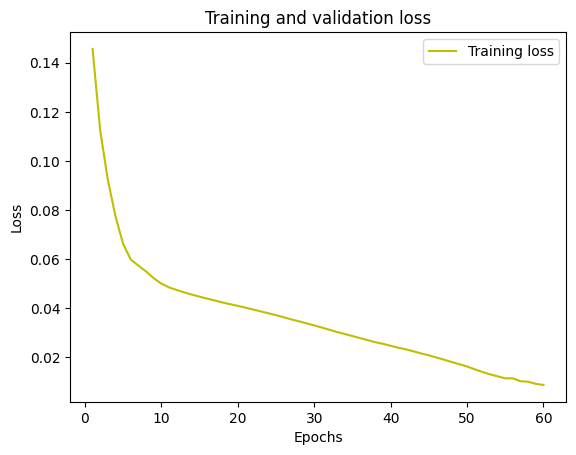

In [39]:
loss = model_res.history['loss']
#val_loss = model_res.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 392ms/step


Text(0.5, 1.0, 'Predicted Mask')

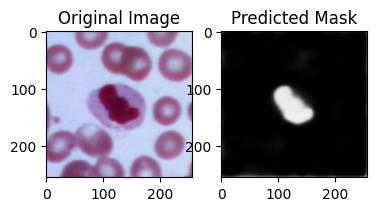

In [19]:
from tensorflow.keras.models import load_model
model_2 = load_model('Blood cell_unet-model_2.h5',compile=False)
# Reshape the input to match the expected dimensions
input_img = train[0]
input_img = tf.expand_dims(input_img, axis=0)  # Add batch dimension
input_img = tf.image.resize(input_img, [256, 256])  # Resize to expected height and width

# Now predict
pre_dat = model_2.predict(input_img)
# Plot original image
plt.subplot(131)
plt.imshow(tf.squeeze(input_img).numpy())
plt.title('Original Image')
# Plot predicted mask
plt.subplot(132)
plt.imshow(pre_dat[0], cmap='gray')
plt.title('Predicted Mask')


1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Predicted Mask')

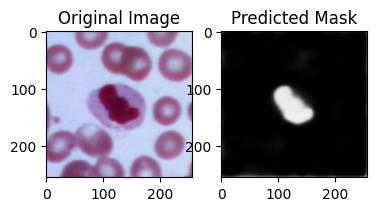

In [15]:
from tensorflow.keras.models import load_model
model_2 = load_model('Blood cell_unet-model_2.h5',compile=False)
# Reshape the input to match the expected dimensions
input_img = train[0]
input_img = tf.expand_dims(input_img, axis=0)  # Add batch dimension
input_img = tf.image.resize(input_img, [256, 256])  # Resize to expected height and width

# Now predict
pre_dat = model_2.predict(input_img)
# Plot original image
plt.subplot(131)
plt.imshow(tf.squeeze(input_img).numpy())
plt.title('Original Image')
# Plot predicted mask
plt.subplot(132)
plt.imshow(pre_dat[0], cmap='gray')
plt.title('Predicted Mask')


1/1 [==============================] - 0s 362ms/step
Jaccard Coefficient: 0.099903084


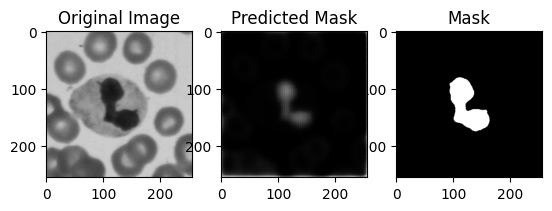

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# Load image
img_lst = '95-8-6-1_2_1.jpg'

img = tf.io.read_file(img_lst)
img1 = tf.image.decode_jpeg(img)
img2 = tf.keras.layers.Lambda(lambda x: x / 255)(img1)
img3 = tf.image.resize(img2, [256, 256])
img4 = tf.image.rgb_to_grayscale(img3)  # Convert to grayscale (single channel)

# Convert grayscale to 3 channels
img4_rgb = tf.image.grayscale_to_rgb(img4)  # Create a 3-channel image from the grayscale image

# Add batch dimension
img4_rgb = tf.expand_dims(img4_rgb, axis=0)  # This will change the shape to (1, 256, 256, 3)

plt.subplot(131)
plt.imshow(tf.squeeze(img4_rgb).numpy())
plt.title('Original Image')

# Load mask
msk_lst = '95-8-6-1_2_1.tif'

msk = plt.imread(msk_lst)
msk1 = np.expand_dims(msk, axis=-1)
msk2 = tf.image.resize(msk1, [256, 256])

plt.subplot(133)
plt.imshow(msk2, cmap='gray')
plt.title('Mask')

# Predict
class CustomConv2DTranspose(tf.keras.layers.Conv2DTranspose):
    def __init__(self, *args, groups=1, **kwargs):
        super().__init__(*args, **kwargs)

with tf.keras.utils.custom_object_scope({'Conv2DTranspose': CustomConv2DTranspose}):
    model_2 = load_model('Blood cell_unet-model_2.h5', compile=False)
    pre_dat = model_2.predict(img4_rgb)
    
# Plot predicted mask
plt.subplot(132)
plt.imshow(pre_dat[0], cmap='gray')
plt.title('Predicted Mask')

# IOU (Intersection over Union)
t = K.flatten(msk2)  # Flatten the mask
p = K.flatten(pre_dat[0])  # Flatten the predicted mask

# Custom Jaccard Index calculation
def jacard_coef(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + smooth)

print("Jaccard Coefficient:", jacard_coef(t, p).numpy())